# "Next Generation Reservoir Computing"

Daniel J. Gauthier, Erik Bollt, Aaron Grifﬁth & Wendson A. S. Barbosa


*Nature Communications*, vol. 12, no. 1, p. 5564, Sep. 2021, doi: 10.1038/s41467-021-25801-2.


In [1]:
import matplotlib.pyplot as plt
import numpy as np

from reservoirpy.datasets import lorenz, doublescroll
from reservoirpy.observables import nrmse
from reservoirpy.nodes import Ridge, NVAR

%matplotlib inline

from IPython.core.display import HTML
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

## Authors abstract

"Reservoir computing is a best-in-class machine learning algorithm for processing information
generated by dynamical systems using observed time-series data. Importantly, it requires
very small training data sets, uses linear optimization, and thus requires minimal computing
resources. However, the algorithm uses randomly sampled matrices to deﬁne the underlying
recurrent neural network and has a multitude of metaparameters that must be optimized.
Recent results demonstrate the equivalence of reservoir computing to nonlinear vector
autoregression, which requires no random matrices, fewer metaparameters, and provides
interpretable results. Here, we demonstrate that nonlinear vector autoregression excels at
reservoir computing benchmark tasks and requires even shorter training data sets and
training time, heralding the next generation of reservoir computing."


## Implementation using *ReservoirPy*

This notebook is provided as a demo of the `NVAR` node in ReservoirPy, implementing the method described in the paper *Next Generation Reservoir Computing* by Gauthier *et al.*

The nonlinear vector autoregressive (NVAR) machine implements the following equations. The state $\mathbb{O}_{total}$ of the NVAR first contains a serie of linear features $\mathbb{O}_{lin}$ made of input data concatenated with delayed inputs:

$$
\mathbb{O}_{lin}[t] = \mathbf{X}[t] \oplus \mathbf{X}[t - s] \oplus \mathbf{X}[t - 2s] \oplus \dots \oplus \mathbf{X}[t - (k-1)s]
$$

where $\mathbf{X}[t]$ are the inputs at time $t$, $k$ is the delay and $s$ is the strides (only one input every $s$ inputs within the delayed inputs is used). The operator $\oplus$ denotes the concatenation.

In addition to these linear features, nonlinear representations $\mathbb{O}_{nonlin}^n$ of the inputs are contructed using all unique monomials of order $n$ of these inputs:

$$
\mathbb{O}_{nonlin}^n[t] = \mathbb{O}_{lin}[t] \otimes \mathbb{O}_{lin}[t] \overbrace{\otimes \dots \otimes}^{n-1~\mathrm{times}} \mathbb{O}_{lin}[t]
$$

where $\otimes$ is the operator denoting an outer product followed by the selection of all unique monomials generated by this outer product. Under the hood, this product is computed by ReservoirPy by finding all unique combinations of input features and multiplying each combination of terms.

Finally, all representations are gathered to form the final feature vector $\mathbb{O}_{total}$:

$$
\mathbb{O}_{total} = \mathbb{O}_{lin}[t] \oplus \mathbb{O}_{nonlin}^n[t]
$$

Tikhonov regression is used to compute the readout weights using this feature vector and some target values, in an offline way (we will simply use ReservoirPy's `Ridge` node of for this).

![Fig. 1 A traditional RC (Reservoir Computing machine) is implicit in an NG-RC (Next Generation Reservoir Computing machine). (top) A traditional RC processes time-series data associated with a strange attractor (blue, middle left)
using an artiﬁcial recurrent neural network. The forecasted strange attractor (red, middle right) is a linear weight of the reservoir states. (bottom) The NG-
RC performs a forecast using a linear weight of time-delay states (two times shown here) of the time series data and nonlinear functionals of this data
(quadratic functional shown here).](Fig1.png)

**Fig. 1** A traditional (Reservoir Computing machine) is implicit in an NG-RC (Next Generation Reservoir Computing machine). *(top)* A traditional RC processes time-series data associated with a strange attractor (blue, middle left)
using an artiﬁcial recurrent neural network. The forecasted strange attractor (red, middle right) is a linear weight of the reservoir states. *(bottom)* The NG-RC performs a forecast using a linear weight of time-delay states (two times shown here) of the time series data and nonlinear functionals of this data
(quadratic functional shown here). Figure and legend from Gauthier *et al.* (2021).

## 1. NVAR for Lorenz strange attractor forecating

Lorenz attractor is defined by three coupled differential equations:

$$
\begin{split}
\dot{x} &= 10(y-x)\\
\dot{y} &= x(28-z)\\
\dot{z} &= xy - \frac{8z}{3}
\end{split}
$$

In [2]:
# time step duration (in time unit)
dt = 0.025
# training time (in time unit)
train_time  = 10.
# testing time (idem)
test_time   = 120.
# warmup time (idem): should always be > k * s
warm_time   = 5.

# discretization
train_steps = round(train_time / dt)
test_steps  = round(test_time  / dt)
warm_steps  = round(warm_time  / dt)

In [3]:
x0 = [17.67715816276679, 12.931379185960404, 43.91404334248268]
n_timesteps = train_steps + test_steps + warm_steps

X = lorenz(n_timesteps, x0=x0, h=dt, method="RK23")

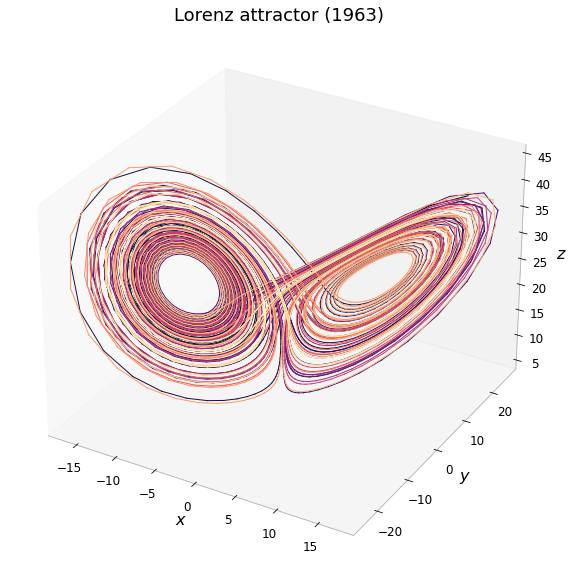

In [4]:
N = train_steps + warm_steps + test_steps

fig = plt.figure(figsize=(10, 10))
ax  = fig.add_subplot(111, projection='3d')
ax.set_title("Lorenz attractor (1963)")
ax.set_xlabel("$x$")
ax.set_ylabel("$y$")
ax.set_zlabel("$z$")
ax.grid(False)

for i in range(N-1):
    ax.plot(X[i:i+2, 0], X[i:i+2, 1], X[i:i+2, 2], color=plt.cm.magma(255*i//N), lw=1.0)

plt.show()

We define a NVAR with delay $k=2$, strides $s=1$ and order $n=2$. The final feature vector $\mathbb{O}_{total}$ will hence be:


$$
\begin{align}
\mathbb{O}_{lin}[t] &=
    \begin{bmatrix}
         x_t\\y_t\\z_t\\x_{t-1}\\y_{t-1}\\z_{t-1}
    \end{bmatrix}
&
\mathbb{O}_{nonlin}[t] &=
    \begin{bmatrix}
       x_t^2\\x_t y_t\\x_t z_t\\x_t x_{t-1}\\x_t y_{t-1}\\x_t
       z_{t-1}\\y_t^2\\y_t z_t\\y_t x_{t-1}\\y_t y_{t-1}\\y_t z_{t-1}\\z_t^2\\z_t x_{t-1}\\z_t y_{t-1}\\z_t
       z_{t-1}\\x_{t-1}^2\\x_{t-1} y_{t-1}\\x_{t-1} z_{t-1}\\y_{t-1}^2\\y_{t-1} z_{t-1}\\z_{t-1}^2
    \end{bmatrix}
\end{align}
$$


$$
\mathbb{O}_{total}[t] = \mathbb{O}_{lin}[t] \oplus \mathbb{O}_{nonlin}[t]
$$

The NVAR is connected to a readout layer with offline learning using regularized linear regression. The regularization parameter is set to $2.5\times10^{-6}$.

The model is first trained to infer the value of $\mathbf{X}[t+1]$ knowing the value of $\mathbf{X}[t]$. This training step enable the model to learn an internal representation of the local dynamics of the attractor.

In [5]:
nvar = NVAR(delay=2, order=2, strides=1)
readout = Ridge(3, ridge=2.5e-6)

model = nvar >> readout

We warmup the NVAR. The warmup time can be as short as only $k \times s$ steps. The NVAR has relevant features as soon as all the delayed signals are non zeros, i.e. as soon as at leas $k \times s$ steps has been stores in the linear vector. Then, train the model to perform one-step-ahead prediction.

In [6]:
Xi  = X[:train_steps+warm_steps-1]
dXi = X[1:train_steps+warm_steps] - X[:train_steps+warm_steps-1]

model = model.fit(Xi, dXi, warmup=warm_steps)

Running Model-0:   0%|                                    | 0/1 [00:00<?, ?it/s]
Running SubModel-9abc06ce-6bed-43fa-8b7e-a8ee4d555630: 599it [00:00, 11637.51it/s]A
Running Model-0: 100%|████████████████████████████| 1/1 [00:00<00:00, 18.75it/s]

Fitting node Ridge-0...


In [7]:
lin = ["$x_t$", "$y_t$", "$z_t$", "$x_{t-1}$", "$y_{t-1}$", "$z_{t-1}$"]

nonlin = []
for idx in nvar._monomial_idx:
    idx = idx.astype(int)
    if idx[0] == idx[1]:
        c = lin[idx[0]][:-1] + "^2$"
    else:
        c = " ".join((lin[idx[0]][:-1], lin[idx[1]][1:]))

    nonlin.append(c)

coefs = ["$c$"] + lin + nonlin

In the plot below are displayed the linear coefficients learned by the model.

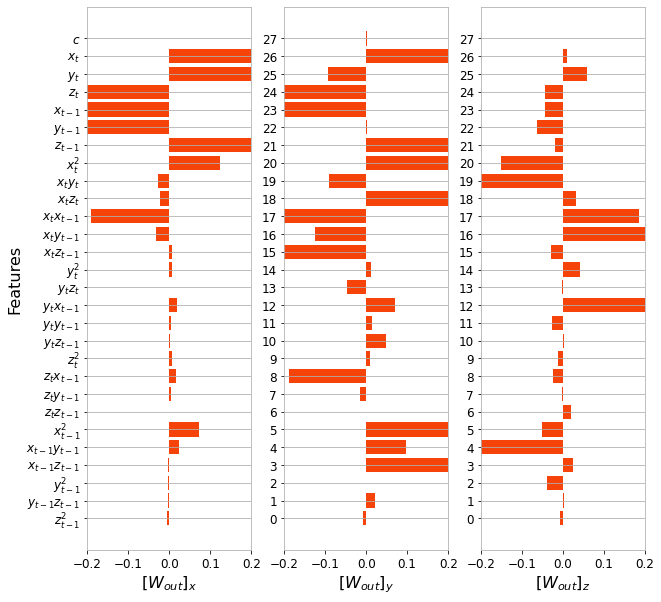

In [8]:
fig = plt.figure(figsize=(10, 10))

Wout = np.r_[readout.bias, readout.Wout]
x_Wout, y_Wout, z_Wout = Wout[:, 0], Wout[:, 1], Wout[:, 2]

ax = fig.add_subplot(131)
ax.set_xlim(-0.2, 0.2)
ax.grid(axis="y")
ax.set_xlabel("$[W_{out}]_x$")
ax.set_ylabel("Features")
ax.set_yticks(np.arange(len(coefs)))
ax.set_yticklabels(coefs[::-1])
ax.barh(np.arange(x_Wout.size), x_Wout.ravel()[::-1])

ax1 = fig.add_subplot(132)
ax1.set_xlim(-0.2, 0.2)
ax1.grid(axis="y")
ax1.set_yticks(np.arange(len(coefs)))
ax1.set_xlabel("$[W_{out}]_y$")
ax1.barh(np.arange(y_Wout.size), y_Wout.ravel()[::-1])

ax2 = fig.add_subplot(133)
ax2.set_xlim(-0.2, 0.2)
ax2.grid(axis="y")
ax2.set_yticks(np.arange(len(coefs)))
ax2.set_xlabel("$[W_{out}]_z$")
ax2.barh(np.arange(z_Wout.size), z_Wout.ravel()[::-1])

plt.show()

In [9]:
nvar.run(X[warm_steps+train_steps-2:warm_steps+train_steps])
u = X[warm_steps+train_steps]
res = np.zeros((test_steps, readout.output_dim))
for i in range(test_steps):
    u = u + model(u)
    res[i, :] = u

Running NVAR-0: 100%|███████████████████████████| 2/2 [00:00<00:00, 4718.00it/s]


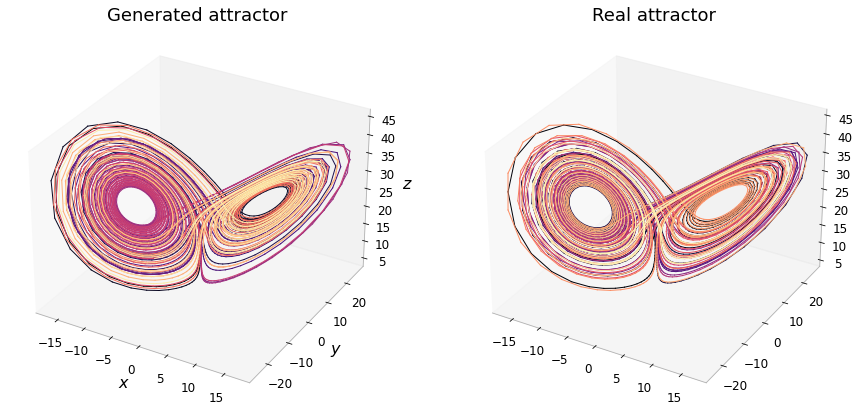

In [10]:
N = test_steps
Y = X[warm_steps+train_steps:]

fig = plt.figure(figsize=(15, 10))
ax  = fig.add_subplot(121, projection='3d')
ax.set_title("Generated attractor")
ax.set_xlabel("$x$")
ax.set_ylabel("$y$")
ax.set_zlabel("$z$")
ax.grid(False)

for i in range(N-1):
    ax.plot(res[i:i+2, 0], res[i:i+2, 1], res[i:i+2, 2], color=plt.cm.magma(255*i//N), lw=1.0)

ax2 = fig.add_subplot(122, projection='3d')
ax2.set_title("Real attractor")
ax2.grid(False)

for i in range(N-1):
    ax2.plot(Y[i:i+2, 0], Y[i:i+2, 1], Y[i:i+2, 2], color=plt.cm.magma(255*i//N), lw=1.0)

## 2. NVAR for double scroll strange attractor forecasting

Same exercise as above, but this time using the double scroll attractor defined by:

$$
\begin{split}
\frac{dx}{dt} &= a(y - x) \\
\frac{dy}{dt} &= (c - a)x - xz + cy \\
\frac{dz}{dt} &= xy - bz
\end{split}
$$

In [11]:
dt = 0.25
train_time  = 100.
test_time   = 800.
warm_time   = 1.
train_steps = round(train_time / dt)
test_steps  = round(test_time  / dt)
warm_steps  = round(warm_time  / dt)

In [12]:
x0 = [0.37926545, 0.058339, -0.08167691]
n_timesteps = train_steps + test_steps + warm_steps

X = doublescroll(n_timesteps, x0=x0, h=dt, method="RK23")

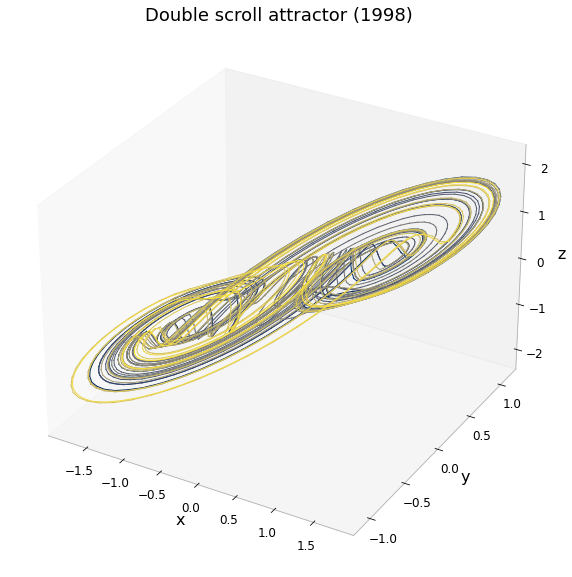

In [13]:
N = train_steps + warm_steps + test_steps

fig = plt.figure(figsize=(10, 10))
ax  = fig.add_subplot(111, projection='3d')
ax.set_title("Double scroll attractor (1998)")
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")
ax.grid(False)

for i in range(N-1):
    ax.plot(X[i:i+2, 0], X[i:i+2, 1], X[i:i+2, 2], color=plt.cm.cividis(255*i//N), lw=1.0)

plt.show()

In [14]:
nvar = NVAR(delay=2, order=3, strides=1)
# The attractor is centered around (0, 0, 0), no bias is required
readout = Ridge(3, ridge=2.5e-6, input_bias=False)
model = nvar >> readout

In [15]:
Xi  = X[:train_steps+warm_steps-1]
dXi = X[1:train_steps+warm_steps] - X[:train_steps+warm_steps-1]

model = model.fit(Xi, dXi, warmup=warm_steps)

Running Model-1:   0%|                                    | 0/1 [00:00<?, ?it/s]
Running SubModel-9683ad9f-e177-4bfe-81fb-4cfd163a39b6: 403it [00:00, 11025.33it/s]A
Running Model-1: 100%|████████████████████████████| 1/1 [00:00<00:00, 25.76it/s]


Fitting node Ridge-1...


In [16]:
nvar.run(X[warm_steps+train_steps-2:warm_steps+train_steps])
u = X[warm_steps+train_steps]
res = np.zeros((test_steps, readout.output_dim))
for i in range(test_steps):
    u = u + model(u)
    res[i, :] = u

Running NVAR-1: 100%|███████████████████████████| 2/2 [00:00<00:00, 6065.52it/s]


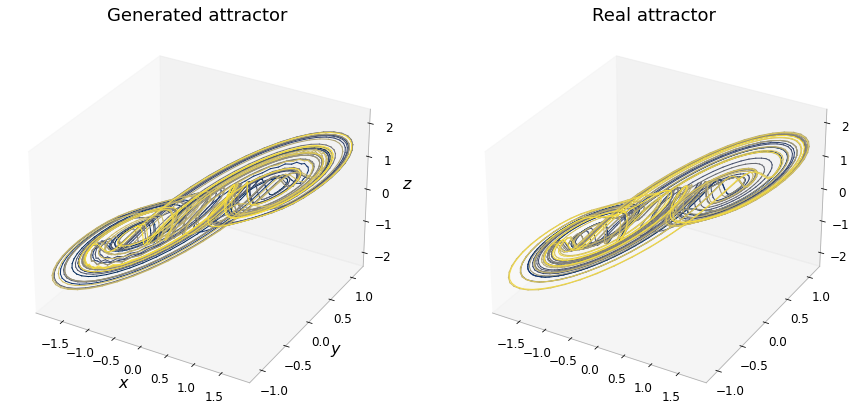

In [17]:
N = test_steps
Y = X[warm_steps+train_steps:]

fig = plt.figure(figsize=(15, 10))
ax  = fig.add_subplot(121, projection='3d')
ax.set_title("Generated attractor")
ax.set_xlabel("$x$")
ax.set_ylabel("$y$")
ax.set_zlabel("$z$")
ax.grid(False)

for i in range(N-1):
    ax.plot(res[i:i+2, 0], res[i:i+2, 1], res[i:i+2, 2], color=plt.cm.cividis(255*i//N), lw=1.0)

ax2 = fig.add_subplot(122, projection='3d')
ax2.set_title("Real attractor")
ax2.grid(False)

for i in range(N-1):
    ax2.plot(Y[i:i+2, 0], Y[i:i+2, 1], Y[i:i+2, 2], color=plt.cm.cividis(255*i//N), lw=1.0)

## 3. Reconstruction of $z$ coordinate of Lorenz system from $(x, y)$

We now want to predict coordinate $z[t]$ at time $t$ of a point in the Lorenz attractor given the two other coordinates $(x[t-1], y[t-1])$ at time $t -1$.

In [18]:
# time step duration (in time unit)
dt = 0.05
# training time (in time unit)
train_time  = 20.
# testing time (idem)
test_time   = 45.
# warmup time (idem): should always be > k * s
warm_time   = 5.

# discretization
train_steps = round(train_time / dt)
test_steps  = round(test_time  / dt)
warm_steps  = round(warm_time  / dt)

In [19]:
x0 = [17.67715816276679, 12.931379185960404, 43.91404334248268]
n_timesteps = train_steps + test_steps + warm_steps

X = lorenz(n_timesteps, x0=x0, h=dt, method="RK23")

In [20]:
nvar = NVAR(delay=4, order=2, strides=5)
readout = Ridge(1, ridge=0.05)

model = nvar >> readout

In [21]:
xy  = X[:train_steps+warm_steps-1, :2]
z   = X[1:train_steps+warm_steps, 2][:, np.newaxis]

model = model.fit(xy, z, warmup=warm_steps)

Running Model-2:   0%|                                    | 0/1 [00:00<?, ?it/s]
Running SubModel-4b2b928c-1efa-41e9-b1ea-547c6a2a9a8f: 499it [00:00, 11629.42it/s]A
Running Model-2: 100%|████████████████████████████| 1/1 [00:00<00:00, 21.13it/s]

Fitting node Ridge-2...


In [22]:
_ = nvar.run(X[train_steps:warm_steps+train_steps, :2])

xy_test = X[warm_steps+train_steps:-1, :2]
res = model.run(xy_test)

Running NVAR-2: 100%|██████████████████████| 100/100 [00:00<00:00, 15064.12it/s]
Running Model-2: 899it [00:00, 11178.15it/s]                                    


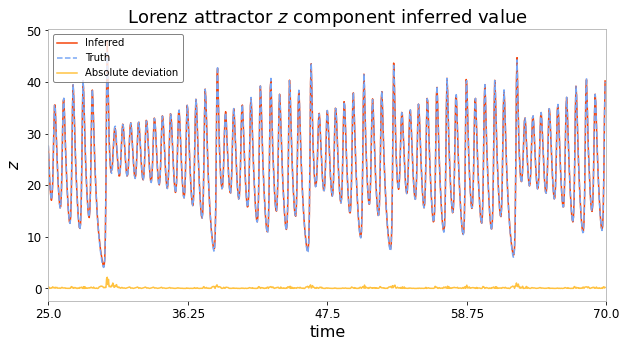

In [23]:
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(111)
ax.plot(res, label="Inferred")
ax.plot(X[warm_steps+train_steps+1:, 2], label="Truth", linestyle="--")
ax.plot(abs(res[:, 0] - X[warm_steps+train_steps+1:, 2]), label="Absolute deviation")
ax.set_ylabel("$z$")
ax.set_xlabel("time")
ax.set_title("Lorenz attractor $z$ component inferred value")
ax.set_xticks(np.linspace(0, 900, 5))
ax.set_xticklabels(np.linspace(0, 900, 5) * dt + train_time + warm_time)
plt.legend()
plt.show()